## In this notebook, we test how does a model that uses Team 1 as the team that starts on the CT Side

In [106]:
# Modues to be used
import os
import json
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [48]:
# First we read the maps

# -> Player dictionary with the dataFrames
f = open('data/dict_player.pickle', 'rb')
dict_player = pickle.load(f)

# -> Map dataFrames
f = open('data/df_map.pickle','rb')
df_map = pickle.load(f)

# -> Map dictionary
f = open('data/dict_map.pickle','rb')
dict_map = pickle.load(f)

In [26]:
# Here we load the json files to see who started on the CT side
MAPS_PATH = '/home/emmanuel/Desktop/csgo-csv/2019-json/home/emmanuel/Desktop/csgo-data/data/matches-2019/maps/'

dict_ct_start = {}

for fileobj in os.listdir(MAPS_PATH):

    file = os.fsdecode(fileobj)

    map_id = file.strip('hltv_map_')
    map_id = map_id.strip('.json')
    
    #with open(MAPS_PATH + file) as f:
    with open(MAPS_PATH+file) as f:
        try:
            map_id = int(map_id)
            data = json.load(f)
            dict_ct_start[map_id] = data
        except:
            continue

In [31]:
dict_ct_start[81025]['roundHistory'][0]['ctTeam']

5995

In [49]:
df_map['ct_start_team_id'] = df_map['team_id_1']*0

for map_id in dict_ct_start:
    df_map.at[map_id,'ct_start_team_id'] = dict_ct_start[map_id]['roundHistory'][0]['ctTeam']

In [58]:
df_map[ (df_map['ct_start_team_id']>0) & (df_map['team_id_1']!=df_map['ct_start_team_id'])]

,map_id,map,date,event_id,event_name,team_id_1,team_name_1,team_score_1,team_kills_1,team_deaths_1,...,team_rank_1,team_id_2,team_name_2,team_score_2,team_kills_2,team_deaths_2,team_assists_2,team_rank_2,winner,ct_start_team_id
79923,79923,mrg,2019-01-04 15:00:00,4273,Pixel.bet Brawl: Nordic vs. Europe,8248,PACT,9,71.0,98.0,...,77,8846,x-kom,16,98.0,71.0,13.0,86,2,8846
79925,79925,mrg,2019-01-04 17:45:00,4342,ASUS ROG JTR Community Challenge Grand Finals ...,9791,ROG pronax,10,72.0,97.0,...,0,7540,ROG IzakOOO,16,97.0,72.0,15.0,0,2,7540
79926,79926,cch,2019-01-04 19:30:00,4342,ASUS ROG JTR Community Challenge Grand Finals ...,8695,ROG nooky,8,74.0,96.0,...,0,9792,ROG ceh9,16,96.0,75.0,14.0,0,2,9792
79928,79928,mrg,2019-01-05 11:00:00,4342,ASUS ROG JTR Community Challenge Grand Finals ...,7535,ROG SPUNJ,5,53.0,87.0,...,0,8695,ROG nooky,16,87.0,53.0,19.0,0,2,8695
79931,79931,trn,2019-01-05 11:00:00,4342,ASUS ROG JTR Community Challenge Grand Finals ...,9791,ROG pronax,10,83.0,101.0,...,0,7538,ROG fl0m,16,101.0,83.0,22.0,0,2,7538
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
97580,97580,nuke,2020-01-09 19:20:00,5110,IEM Katowice 2020 Europe Closed Qualifier,6667,FaZe,16,89.0,77.0,...,8,4869,ENCE,12,76.0,90.0,12.0,12,1,4869
97581,97581,vertigo,2020-01-09 20:05:00,5110,IEM Katowice 2020 Europe Closed Qualifier,7175,Heroic,5,47.0,91.0,...,16,8068,AGO,16,91.0,48.0,17.0,41,2,8068
97592,97592,nuke,2020-01-10 01:00:00,5164,Aorus League 2019 #4 Northern Cone,10330,Supremacy,16,98.0,69.0,...,0,10578,Infamous,8,69.0,98.0,13.0,0,1,10578
97593,97593,ovp,2020-01-10 00:35:00,5104,IEM Katowice 2020 North America Closed Qualifier,5752,Cloud9,16,77.0,46.0,...,18,9215,MIBR,4,46.0,77.0,10.0,14,1,9215


# Let's now try to see if we order the teams by their CT/T Start

In [80]:
map_name = 'trn'

DAYS_WEIGHT = 365

time_1 = datetime.now()

# df_tmp = df_map[ (df_map['date']>datetime(2019,1,1)) & ( (df_map['team_rank_1']<30) | (df_map['team_rank_2']<30) ) & ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) )]

#df_tmp = df_map[ (df_map['date']>datetime(2018,1,1)) & ( (df_map['team_rank_1']<30) | (df_map['team_rank_2']<30) ) & ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) )]


# df_tmp = df_map[ (df_map['map']==map_name) &
#     (df_map['date']>datetime(2019,1,1)) & ( (df_map['team_rank_1']<20) & (df_map['team_rank_2']<20) ) & ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) )]

df_tmp = df_map[ (df_map['map']==map_name) & (df_map['date']>datetime(2019,1,1)) &
    ( (df_map['team_rank_1']>0) & (df_map['team_rank_2']>0) ) ]


dict_train = {}

print( len( df_tmp['map_id']) )

for map_id in df_tmp['map_id'][:500]:

    map_date = df_tmp.loc[map_id]['date']

    dict_train[map_id] = {}    

    # Here we are taking the rankings to be non-zero
    rank_1 = df_tmp.loc[map_id]['team_rank_1']
    rank_2 = df_tmp.loc[map_id]['team_rank_2']

    team_id_1 = df_tmp.loc[map_id]['team_id_1']
    team_id_2 = df_tmp.loc[map_id]['team_id_2']

    winner = df_tmp.loc[map_id]['winner']

    ct_start_id = df_tmp.loc[map_id]['ct_start_team_id']

    if ct_start_id == team_id_1:
        dict_train[map_id]['t_0_win'] = 1
    else:
        dict_train[map_id]['t_0_win'] = 0
    

    if rank_1 < rank_2:
        fav = 0
        dict_train[map_id]['rank_dif'] = rank_2-rank_1

        if winner == 1:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    else:
        fav = 1
        dict_train[map_id]['rank_dif'] = rank_1-rank_2

        if winner == 2:
            dict_train[map_id]['fav_win'] = 1
        else:
            dict_train[map_id]['fav_win'] = 0

    count_team = -1
    for team_id in dict_map[map_id]:

        count_team = count_team + 1

        weighted_rating    = []
        weighted_kast      = []
        weighted_kpr       = []
        weighted_round_dif = []

        prize = []

        for player_id in dict_map[map_id][team_id]['players_id']:            

            df_aux = dict_player[player_id][ dict_player[player_id]['map']==map_name ]

            date_vec = (map_date-df_aux['date']).astype('timedelta64[D]')

            # date_vec = (map_date-dict_player[player_id]['date']).astype('timedelta64[D]')

            # df_op_rank = df_tmp[ df_tmp['team_rank_1'] ]

            # df_aux = dict_player[player_id][ (date_vec>1) & (date_vec<DAYS_WEIGHT)  ]

            #df_aux = dict_player[player_id][ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            # df_aux = df_aux[ df_aux['map']==map_name ]

            df_aux = df_aux[ (date_vec>1) & (date_vec<DAYS_WEIGHT) ]

            try:
                m = float(1.0)/ sum( date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)]-DAYS_WEIGHT )
            except:
                m = 0.0

            w_i = m * (date_vec[(date_vec>1) & (date_vec<DAYS_WEIGHT)] - DAYS_WEIGHT)
            
            weighted_rating.append( sum(df_aux['rating'] * w_i) )
            weighted_kast.append( sum(df_aux['KAST'] * w_i / 100.0) )
            weighted_kpr.append( sum(df_aux['kills_per_round'] * w_i) )
            weighted_round_dif.append( sum( (df_aux['team_score']-df_aux['op_score']) * w_i) )

            prize_tmp = sum( df_aux['prize'] )
            if prize_tmp > 0.0:
                prize.append( np.log( prize_tmp ) / 12.0 )
            else:
                prize.append( 0.0 )

        order = np.argsort( weighted_rating )

        # if count_team == fav:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_kast'] = weighted_rating[ind]
        #         dict_train[map_id]['t_0_p_'+str(count_p)+'_kpr'] = weighted_rating[ind]
        # else:
        #     count_p = -1
        #     for ind in order:
        #         count_p = count_p + 1
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_rating'] = weighted_rating[ind]
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_kast'] = weighted_rating[ind]
        #         dict_train[map_id]['t_1_p_'+str(count_p)+'_kpr'] = weighted_rating[ind]

        #if count_team == fav:
        if team_id == ct_start_id:

            

            dict_train[map_id]['t_0_avg_rating'] = np.average( weighted_rating )
            dict_train[map_id]['t_0_std_rating'] = np.std( weighted_rating )

            dict_train[map_id]['t_0_avg_kast'] = np.average( weighted_kast )
            dict_train[map_id]['t_0_std_kast'] = np.std( weighted_kast )

            dict_train[map_id]['t_0_avg_kpr'] = np.average( weighted_kpr )
            dict_train[map_id]['t_0_std_kpr'] = np.std( weighted_kpr )

            dict_train[map_id]['t_0_avg_rd'] = np.average( weighted_round_dif )
            dict_train[map_id]['t_0_std_rd'] = np.std( weighted_round_dif )

            dict_train[map_id]['prize_0'] = np.average( prize )
            
        else:
            
            dict_train[map_id]['t_1_avg_rating'] = np.average( weighted_rating )
            dict_train[map_id]['t_1_std_rating'] = np.std( weighted_rating )

            dict_train[map_id]['t_1_avg_kast'] = np.average( weighted_kast )
            dict_train[map_id]['t_1_std_kast'] = np.std( weighted_kast )

            dict_train[map_id]['t_1_avg_kpr'] = np.average( weighted_kpr )
            dict_train[map_id]['t_1_std_kpr'] = np.std( weighted_kpr )

            dict_train[map_id]['t_1_avg_rd'] = np.average( weighted_round_dif )
            dict_train[map_id]['t_1_std_rd'] = np.std( weighted_round_dif )

            dict_train[map_id]['prize_1'] = np.average( prize )

    

time_2 = datetime.now()

print( time_2-time_1 )
#date_vec

1389
0:01:15.362840


In [154]:

df_train = pd.DataFrame.from_dict(dict_train,orient='index')

for map_id in df_train.index:
    #df_train.at[map_id,'rank_rating'] = np.log(df_train.at[map_id,'rank_dif']+1)
    #df_train.at[map_id,'rank_rating'] = df_train.at[map_id,'rank_dif']

    # df_train.at[map_id,'rating_dif'] = 1.0*(dict_train[map_id]['t_0_avg_rating'] - dict_train[map_id]['t_1_avg_rating'])**1
    df_train.at[map_id,'rating_dif'] = 1.0*(dict_train[map_id]['t_0_avg_rd'] - dict_train[map_id]['t_1_avg_rd'])**1
    #df_train.at[map_id,'kast_dif'] = 1.0*(dict_train[map_id]['t_0_avg_kast'] - dict_train[map_id]['t_1_avg_kast'])**1
    df_train.at[map_id,'prize_dif'] = df_train.at[map_id,'prize_0'] - df_train.at[map_id,'prize_1'] 

df_train = df_train.fillna(0)

df_train.tail()

,t_0_win,rank_dif,fav_win,t_0_avg_rating,t_0_std_rating,t_0_avg_kast,t_0_std_kast,t_0_avg_kpr,t_0_std_kpr,t_0_avg_rd,...,t_1_std_rating,t_1_avg_kast,t_1_std_kast,t_1_avg_kpr,t_1_std_kpr,t_1_avg_rd,t_1_std_rd,prize_1,rating_dif,prize_dif
86715,0,18,1,1.000340,0.098876,0.671100,0.028983,0.643182,0.092246,-1.056895,...,0.084387,0.686346,0.032084,0.687130,0.057974,-0.218758,0.690485,0.384047,-0.838137,0.223503
86739,1,15,0,1.177888,0.072199,0.747357,0.021523,0.742559,0.044203,2.587678,...,0.192704,0.580841,0.042688,0.574326,0.125091,-5.317946,1.591777,0.456720,7.905623,-0.054567
86751,1,61,1,1.246496,0.049459,0.752830,0.018779,0.757229,0.037341,5.145151,...,0.340308,0.482635,0.242952,0.453214,0.241426,-5.271347,4.470803,0.000000,10.416499,0.315409
86757,1,6,0,1.122800,0.085284,0.710341,0.022215,0.706974,0.050093,1.637737,...,0.071523,0.640373,0.025884,0.602790,0.057175,-2.200375,1.377584,0.384553,3.838112,0.251080
86765,0,58,0,1.117105,0.084895,0.726778,0.029841,0.714040,0.077201,0.458782,...,0.035132,0.714014,0.022593,0.702107,0.030991,2.617284,0.091192,0.550536,-2.158502,-0.138647


In [198]:
print(df_train['fav_win'].mean())
print(df_train['t_0_win'].mean())

0.616
0.512


<Figure size 720x576 with 0 Axes>

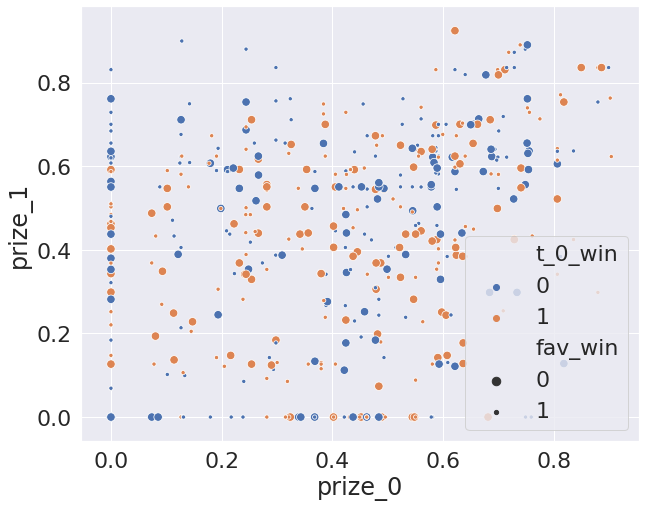

In [105]:
sns.set_style("whitegrid")
sns.set(font_scale=2)
#sns.set_palette("pastel")

plt.figure(figsize=(10,8))
# ax1 = sns.scatterplot(data=data_tmp,x='win',y='ADR')

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_train,x='prize_0',y='prize_1',hue='t_0_win',size='fav_win',alpha=1)

In [155]:
df_train.keys()

Index(['t_0_win', 'rank_dif', 'fav_win', 't_0_avg_rating', 't_0_std_rating',
       't_0_avg_kast', 't_0_std_kast', 't_0_avg_kpr', 't_0_std_kpr',
       't_0_avg_rd', 't_0_std_rd', 'prize_0', 't_1_avg_rating',
       't_1_std_rating', 't_1_avg_kast', 't_1_std_kast', 't_1_avg_kpr',
       't_1_std_kpr', 't_1_avg_rd', 't_1_std_rd', 'prize_1', 'rating_dif',
       'prize_dif'],
      dtype='object')

In [227]:

df_tmp = df_train.drop(['t_0_win', 'rank_dif', 'fav_win', 't_0_avg_rating', 't_0_std_rating',
       't_0_avg_kast', 't_0_std_kast', 't_0_avg_kpr', 't_0_std_kpr',
       't_0_avg_rd', 't_0_std_rd', 'prize_0', 't_1_avg_rating',
       't_1_std_rating', 't_1_avg_kast', 't_1_std_kast', 't_1_avg_kpr',
       't_1_std_kpr', 't_1_avg_rd', 't_1_std_rd', 'prize_1'],axis=1)
       
X_train, X_test, y_train, y_test = train_test_split(df_tmp,df_train['t_0_win'], test_size=0.25)

#X_train, X_test, y_train, y_test = train_test_split(x_orig,y_orig, test_size=0.25)

# Make an instance of the model, and increase the maximum number of iterations to avoid convergence problems
logmodel = LogisticRegression(max_iter=800)



# Training for the model
logmodel.fit(X_train,y_train)

# Now we use the testing data set to make predictions and evaluate the model's performance
predictions = logmodel.predict(X_test)

print('>'+classification_report(y_test,predictions,target_names=['Underdog wins','Favorite wins']))

#predictions[:] = 1


#c_mat = confusion_matrix(y_test.values, predictions)
c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

accuracy = (c_mat[0][0] + c_mat[1][1]) / np.sum(c_mat)
print(accuracy)

>               precision    recall  f1-score   support

Underdog wins       0.55      0.52      0.53        62
Favorite wins       0.55      0.59      0.57        63

     accuracy                           0.55       125
    macro avg       0.55      0.55      0.55       125
 weighted avg       0.55      0.55      0.55       125

[[32 30]
 [26 37]]
0.552


In [153]:
X_train, X_test, y_train, y_test = train_test_split(df_train.drop(['t_0_win','rank_dif','fav_win'],axis=1),df_train['t_0_win'], test_size=0.25)

# fit model no training data
model = XGBClassifier()
model.fit(X_train, y_train)
# make predictions for test data
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
# evaluate predictions
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))

c_mat = confusion_matrix(y_test, predictions)
print( c_mat )

Accuracy: 44.80%
[[32 28]
 [41 24]]
